In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import statsmodels.api as sm
import tensorflow as tf
import datetime as dt
import yfinance as yf
import seaborn as sns
import prophet as pt
import time
import pickle
import joblib

from pylab import rcParams
from vnstock import *
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from vnstock import *
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from sklearn import preprocessing
from sklearn import metrics

sns.set_style('whitegrid')
plt.style.use("default")
yf.pdr_override()
%matplotlib inline


In [45]:
company_overview('FPT')
df = stock_historical_data("FPT", "2021-01-01", '2023-10-8', "1D")
df = pd.DataFrame(df)
display(df.head())
close = df["close"].tolist()


,time,open,high,low,close,volume,ticker
0,2021-01-04,35220,35560,35040,35560,2151300,FPT
1,2021-01-05,35450,37530,35340,37050,2332200,FPT
2,2021-01-06,37280,37590,36820,36880,1796000,FPT
3,2021-01-07,36990,37170,36570,36930,2150200,FPT
4,2021-01-08,37220,37640,36990,37410,2720400,FPT


# EDA

In [46]:
df.describe()


,open,high,low,close,volume
count,689.000000,689.000000,689.000000,689.000000,6.890000e+02
mean,66105.352685,66878.985486,65387.303338,66143.582003,1.840231e+06
std,11465.844891,11573.708115,11344.858043,11452.420171,1.186063e+06
min,34860.000000,35560.000000,34630.000000,34630.000000,1.239000e+05
25%,62870.000000,63600.000000,61790.000000,62870.000000,9.963000e+05
50%,66780.000000,67370.000000,66160.000000,66610.000000,1.592400e+06
75%,71450.000000,72140.000000,70860.000000,71370.000000,2.321400e+06
max,99000.000000,100800.000000,98500.000000,99000.000000,8.399400e+06


In [47]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    689 non-null    object
 1   open    689 non-null    int32 
 2   high    689 non-null    int32 
 3   low     689 non-null    int32 
 4   close   689 non-null    int32 
 5   volume  689 non-null    int64 
 6   ticker  689 non-null    object
dtypes: int32(4), int64(1), object(2)
memory usage: 27.0+ KB


In [48]:
df.reset_index(inplace=True)
df1 = df.drop(['index', 'ticker'], axis = 1)
df.rename(columns={'time':'date'},inplace=True)
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    689 non-null    object
 1   open    689 non-null    int32 
 2   high    689 non-null    int32 
 3   low     689 non-null    int32 
 4   close   689 non-null    int32 
 5   volume  689 non-null    int64 
dtypes: int32(4), int64(1), object(1)
memory usage: 21.7+ KB


C:\Users\lehun\AppData\Local\Temp\ipykernel_15244\143845387.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df, x=df[column], color='#75f8f2')
C:\Users\lehun\AppData\Local\Temp\ipykernel_15244\143845387.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df, x=df[column], color='#75f8f2')
C:

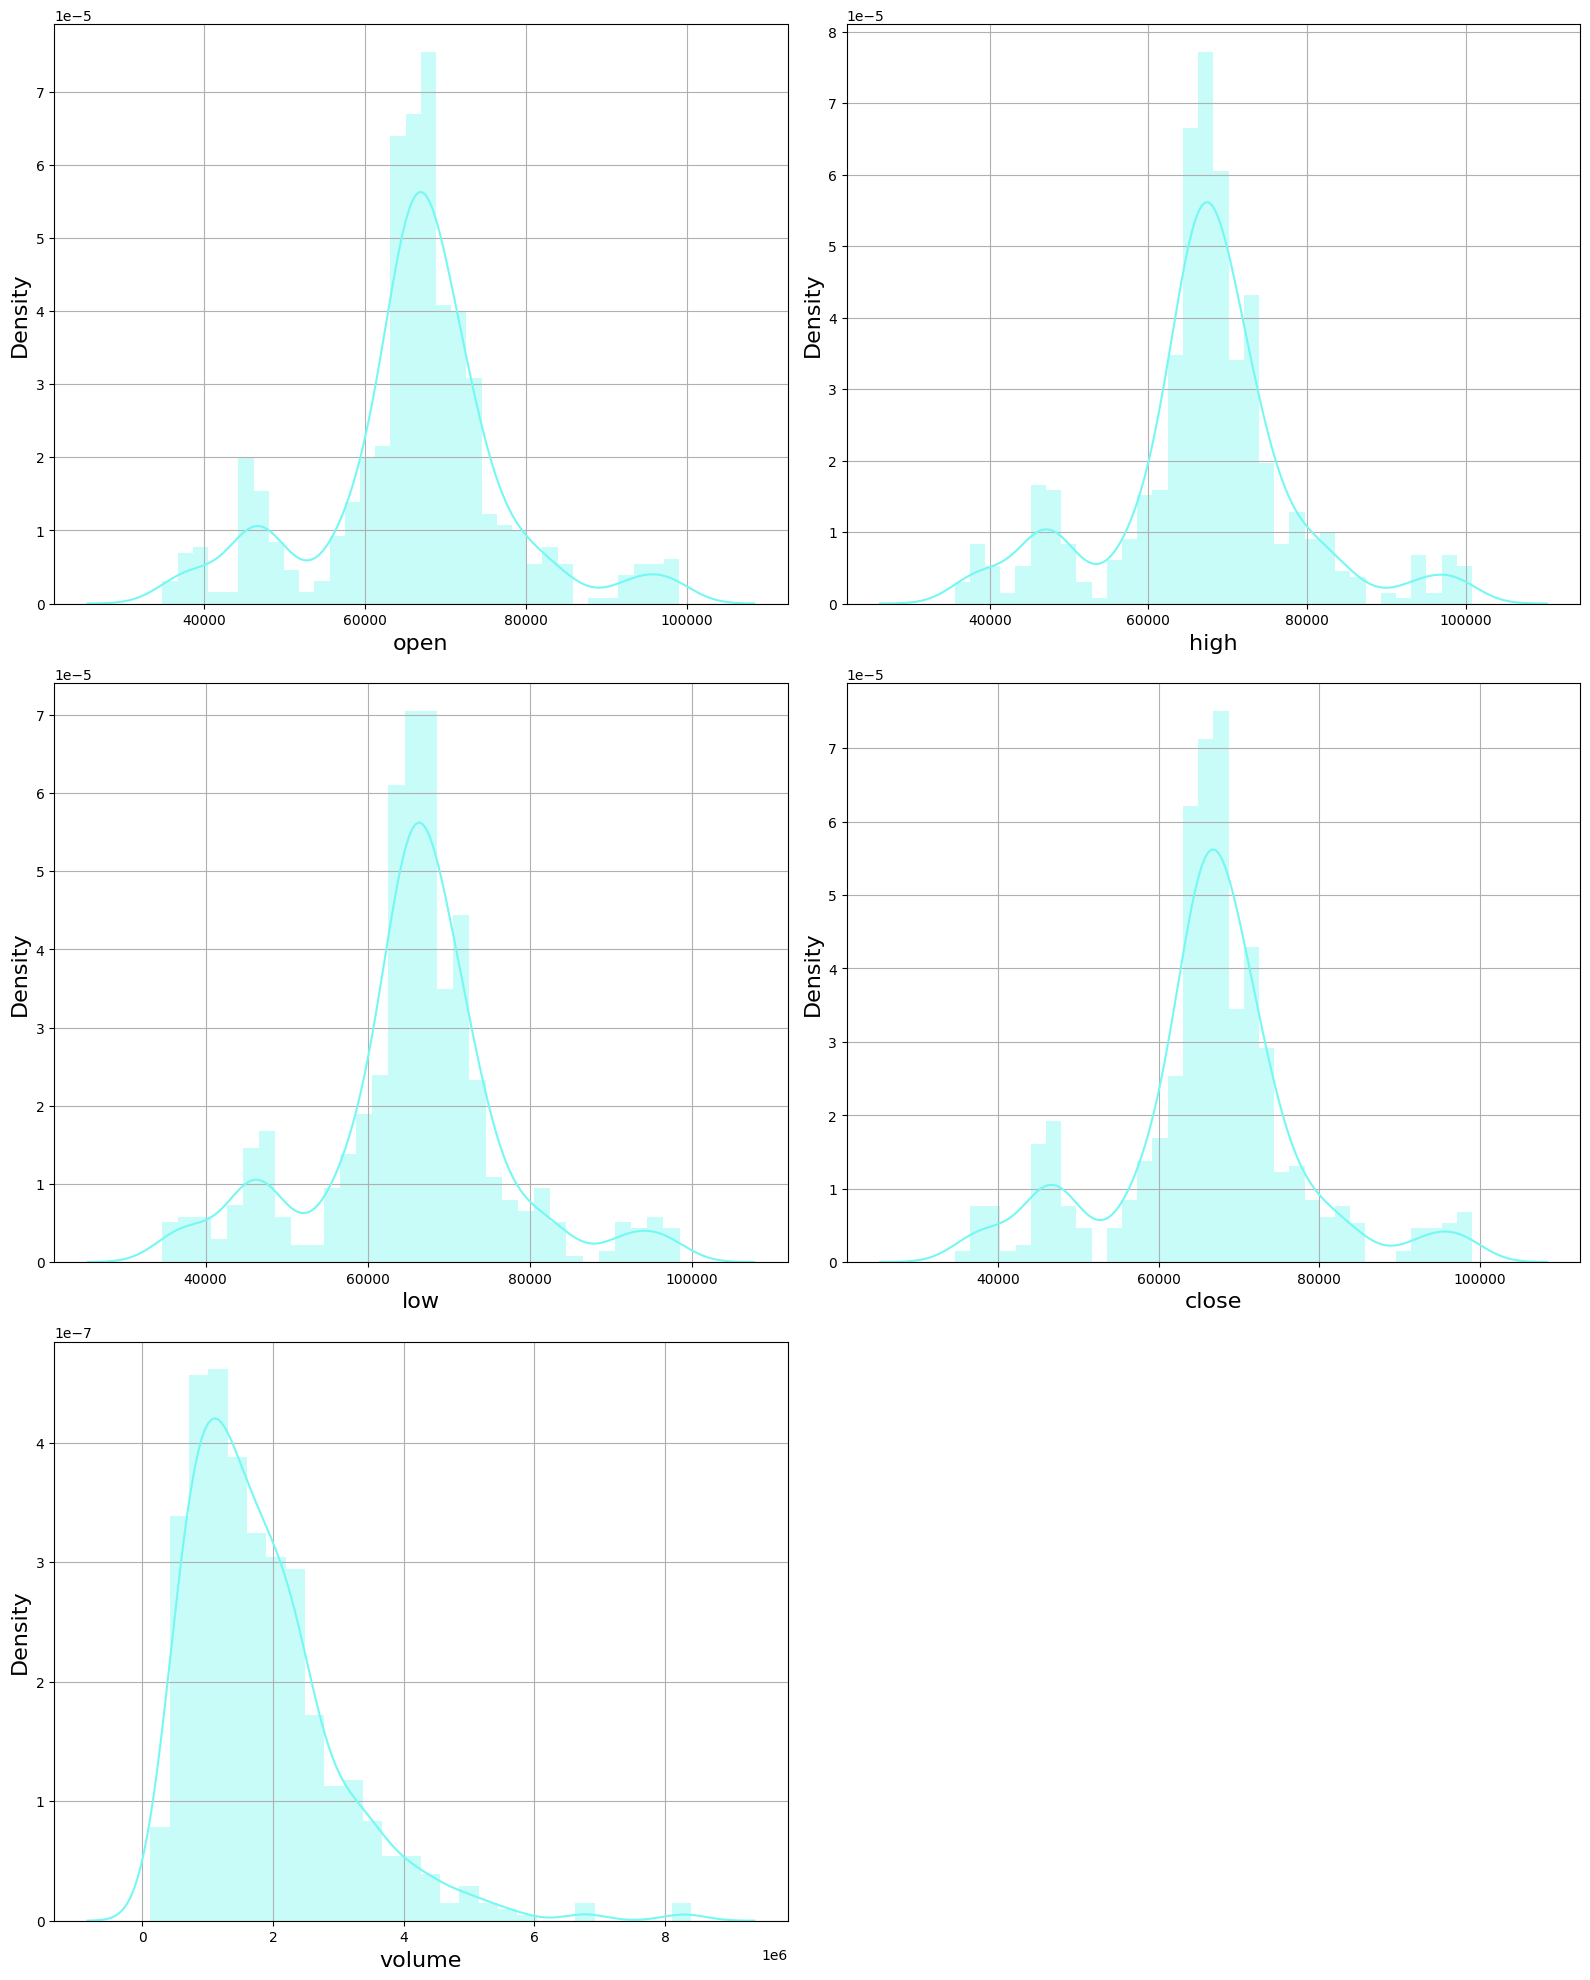

In [49]:
features = ['open', 'high', 'low', 'close', 'volume']
sns.set_palette("PiYG")
plt.figure(figsize=(16,26))
for idx, column in enumerate(features):
    plt.subplot(4, 2, idx + 1)
    sns.distplot(df, x=df[column], color='#75f8f2')
    #plt.title(column, backgroundcolor='black', color='orange', fontsize=25)
    plt.xticks()
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.grid()

plt.tight_layout()
plt.show()


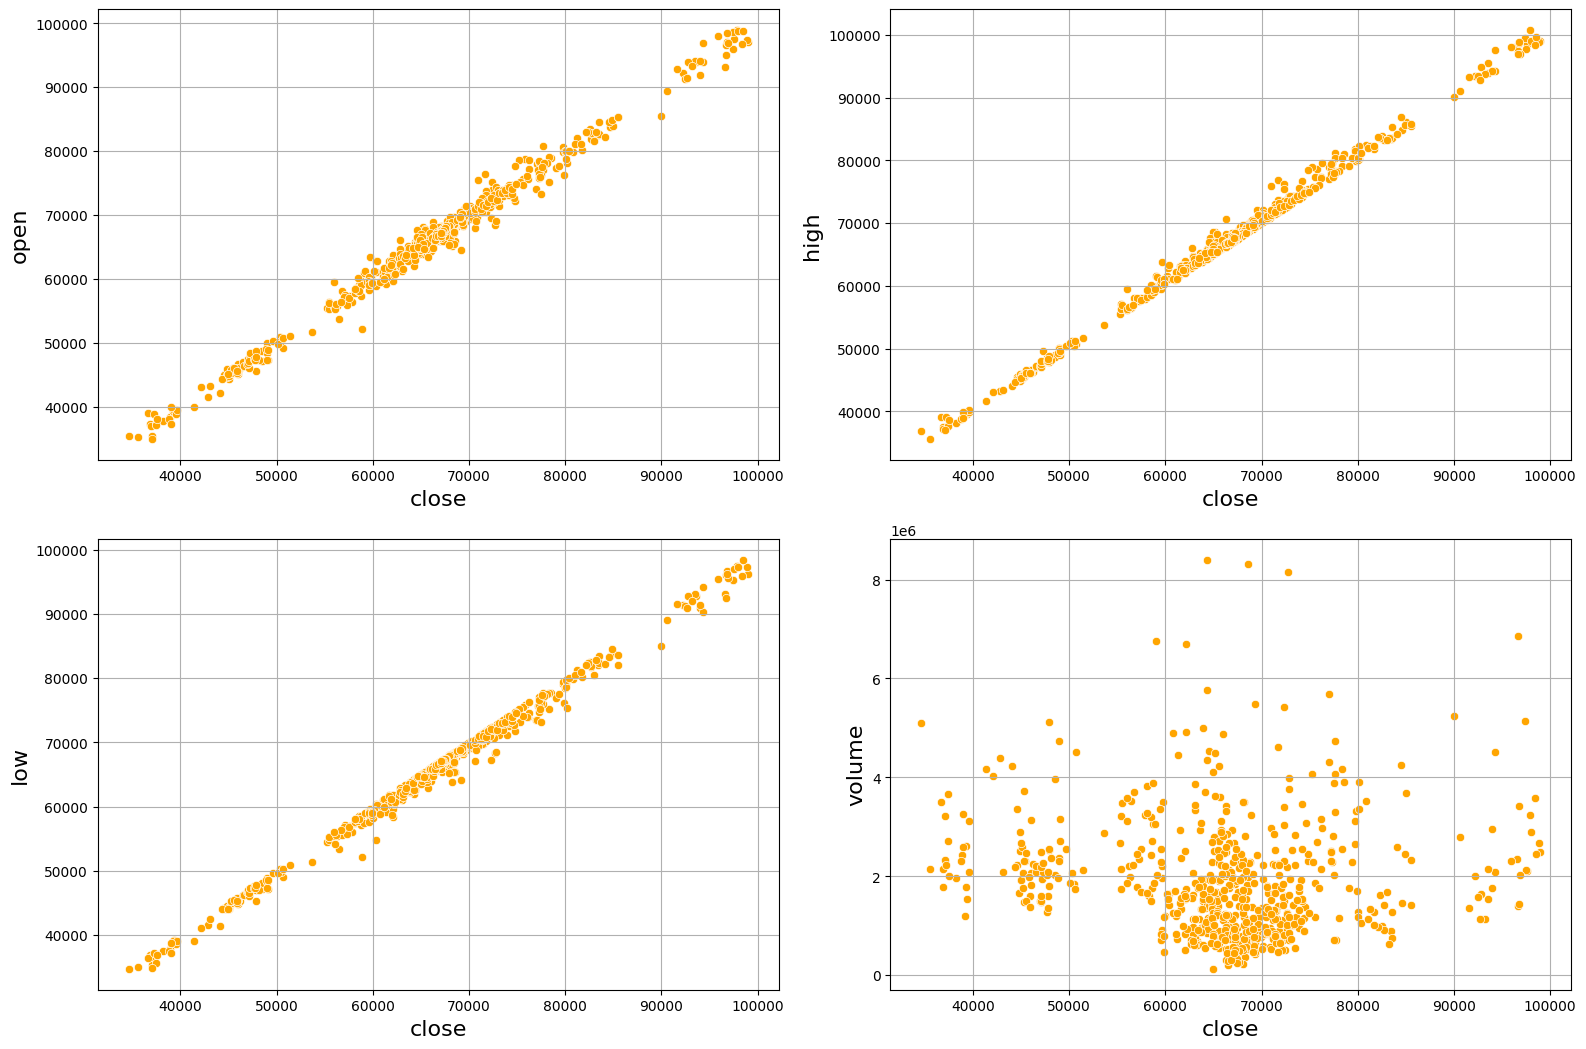

In [50]:
features = ['open', 'high', 'low', 'volume']
sns.set_palette("PiYG")
plt.figure(figsize=(16,26))
for idx, column in enumerate(features):
    plt.subplot(5, 2,  idx + 1)
    sns.scatterplot(x =df['close'], y=df[column] , data = df, color='orange')
    #plt.title(column, backgroundcolor='black', color='#75f8f2', fontsize=25)
    plt.xlabel('close', fontsize=16)
    plt.ylabel(column, fontsize=16)
    plt.grid()
plt.tight_layout()
plt.show()


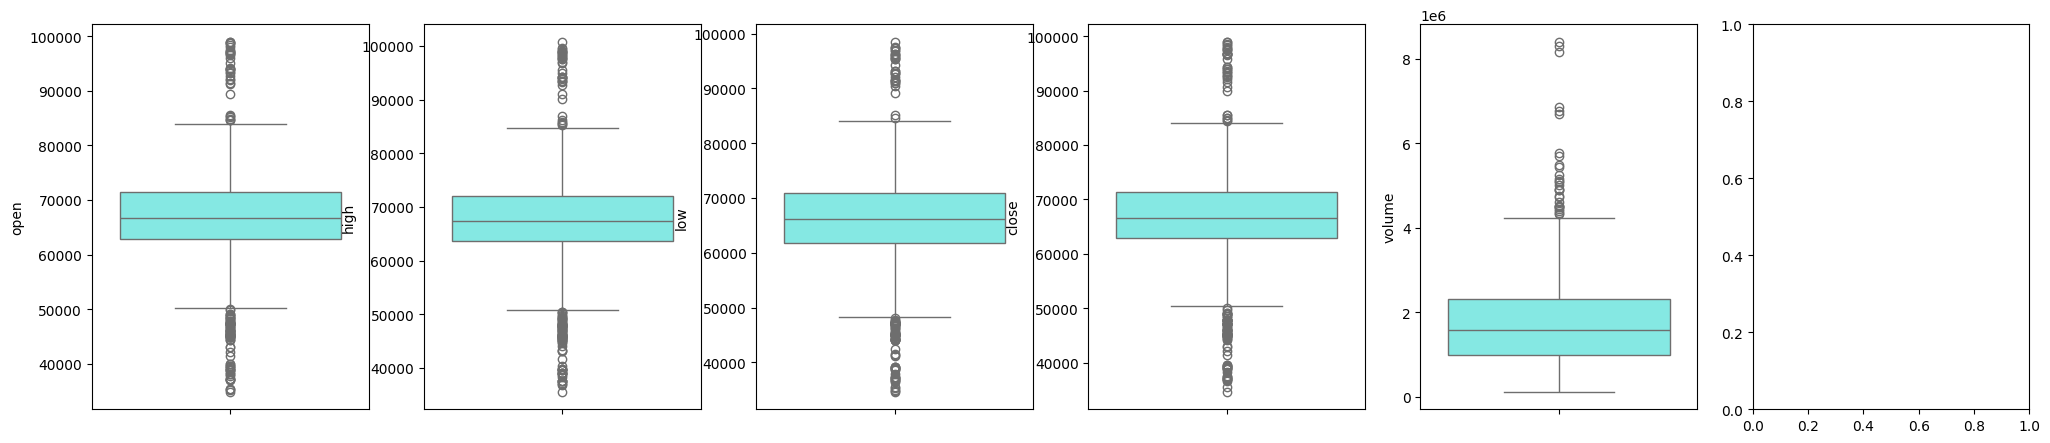

In [51]:
features = ['open', 'high', 'low', 'close', 'volume']
fig  = plt.subplots(nrows = 1, ncols = 6,figsize = (25,5))
for i in range(len(features)) :
    plt.subplot(1, 6,i+1)
    ax = sns.boxplot(df[features[i]], color="#75f8f2")

plt.show()


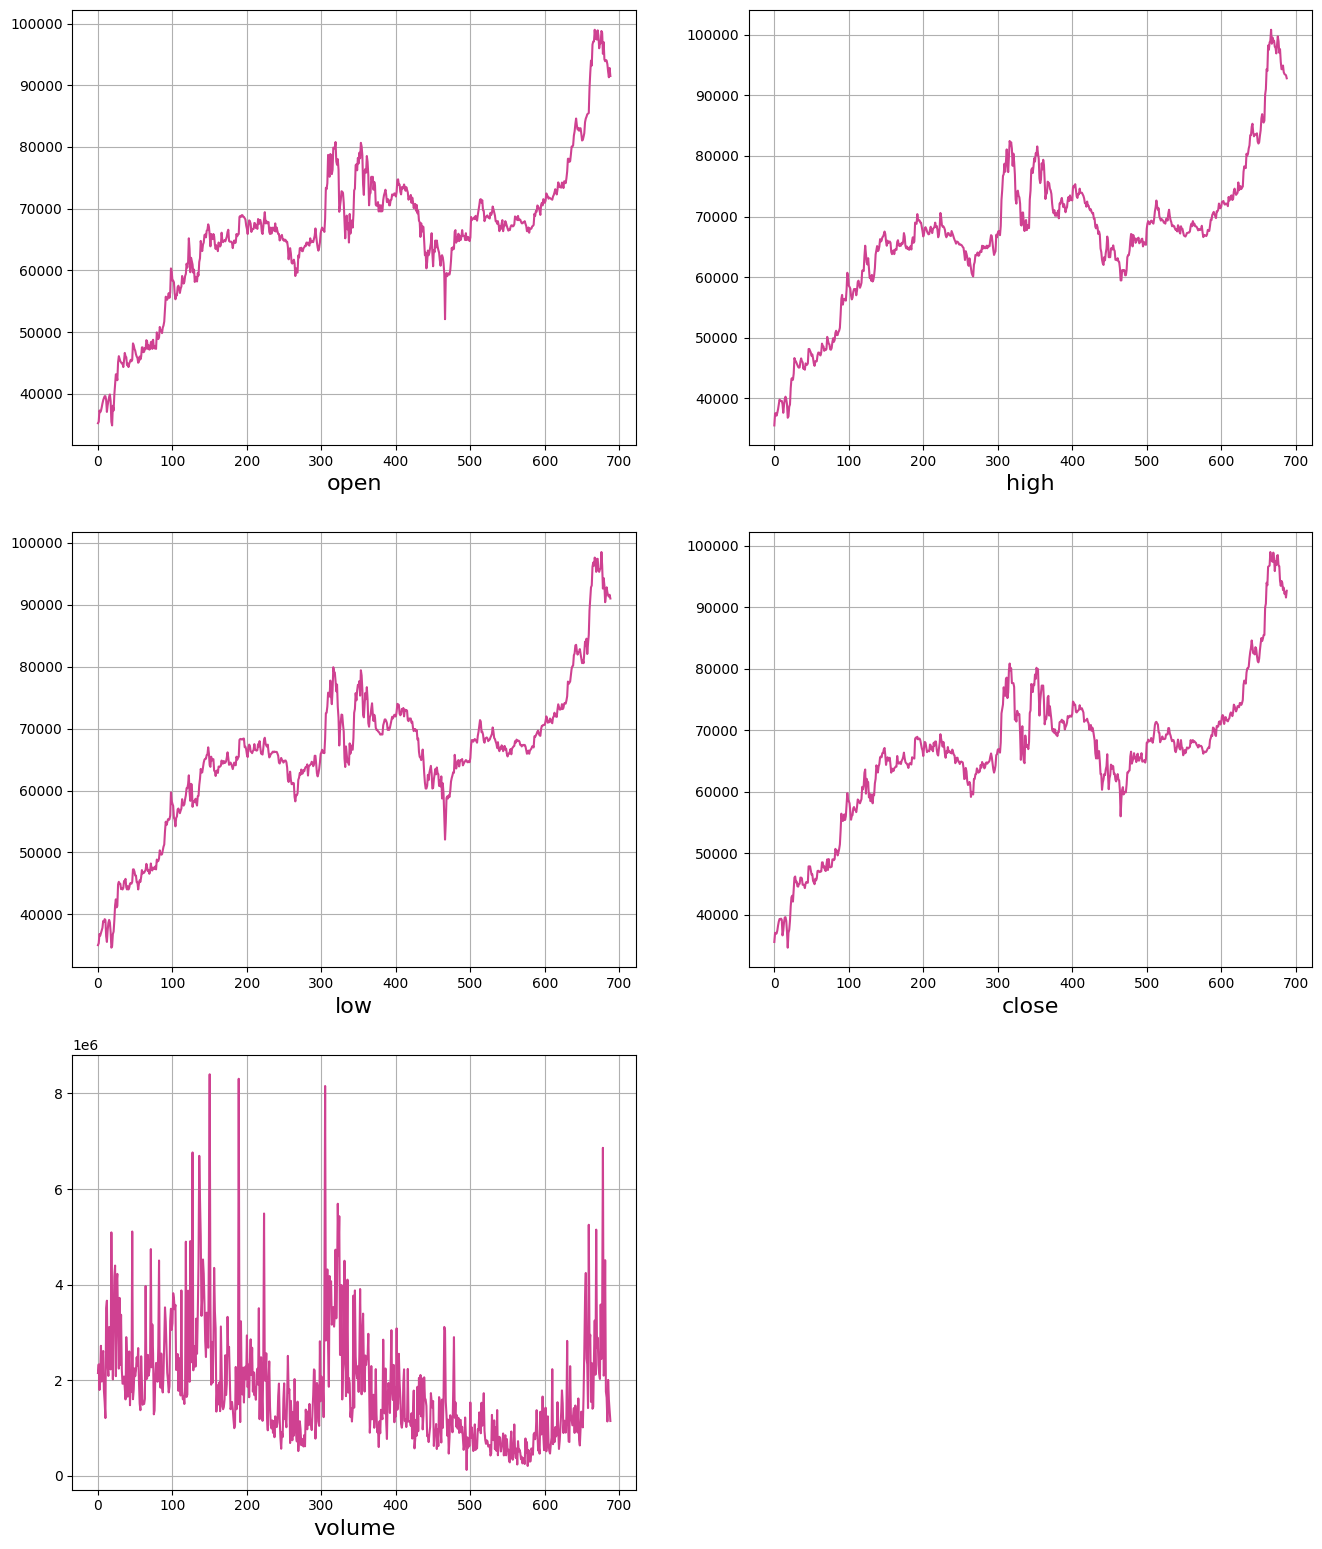

In [52]:
features = ['open', 'high', 'low', 'close', 'volume']
plt.figure(figsize=(16,26))
for idx, column in enumerate(features):
    plt.subplot(4, 2, idx + 1)
    plt.plot(df[column])
    #plt.title(column, backgroundcolor='black', color='orange', fontsize=25)
    plt.xticks()
    plt.xlabel(column, fontsize=16)
    plt.grid()


In [53]:
df1= df.copy()
df1.head()


,index,date,open,high,low,close,volume,ticker
0,0,2021-01-04,35220,35560,35040,35560,2151300,FPT
1,1,2021-01-05,35450,37530,35340,37050,2332200,FPT
2,2,2021-01-06,37280,37590,36820,36880,1796000,FPT
3,3,2021-01-07,36990,37170,36570,36930,2150200,FPT
4,4,2021-01-08,37220,37640,36990,37410,2720400,FPT


In [54]:
plt.style.use("fivethirtyeight")


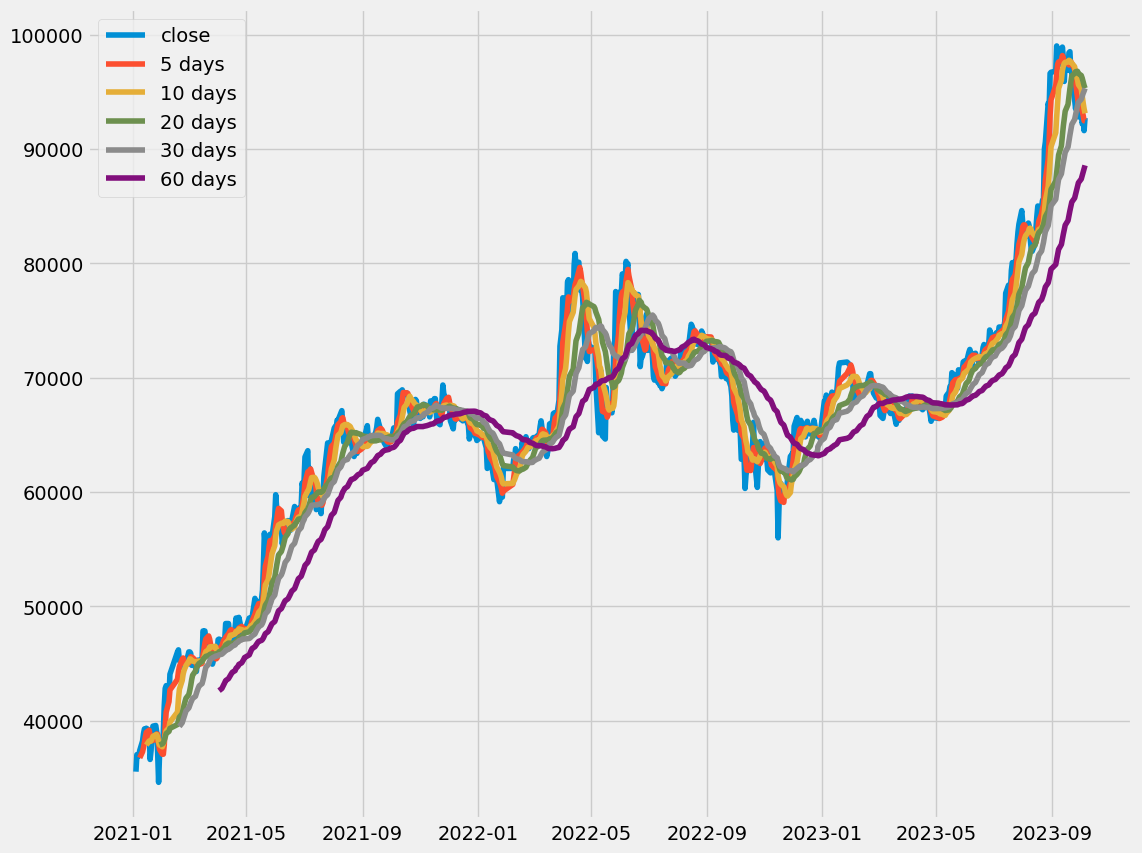

In [55]:
# Checking and choosing the best time step
ma_days = [5, 10, 20, 30, 60]

for MA in ma_days:
    column_name = f"MA in {MA} days"
    df1[column_name] = df1['close'].rolling(MA).mean()

plt.figure(figsize=(12,10))

plt.plot(df1['date'],df1['close'],label='close')
plt.plot(df1['date'],df1['MA in 5 days'],label= '5 days')
plt.plot(df1['date'],df1['MA in 10 days'],label= '10 days')
plt.plot(df1['date'],df1['MA in 20 days'],label= '20 days')
plt.plot(df1['date'],df1['MA in 30 days'],label= '30 days')
plt.plot(df1['date'],df1['MA in 60 days'],label= '60 days')
plt.legend()
plt.show()


In [56]:
df2= df1.copy()
# Normalaze Data For Create Trin and Test with new dataframe with only the 'Close' column
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# fit scaler on only one column('close')
scaled = scaler.fit_transform(df2.filter(['close']))
# now have a scaled dataframe with 'colose column'
df3=pd.DataFrame(scaled, columns=['close'])


In [57]:
print(df3.head())
print(df3.describe())


      close
0  0.014448
1  0.037595
2  0.034954
3  0.035731
4  0.043188
            close
count  689.000000
mean     0.489569
std      0.177915
min      0.000000
25%      0.438714
50%      0.496815
75%      0.570763
max      1.000000


In [58]:
# Finding a Length of %90 from the number of rows to Create a train Dataset (using array)
new_dataset_length = int(np.ceil( len(df2.filter(['close']).values) * .9 ))
print('Length of %90 of Dataset is ',new_dataset_length, ' Therefore, the test data length is ',len(df.close) - new_dataset_length)


Length of %90 of Dataset is  621  Therefore, the test data length is  68


In [59]:
# Create the training data set with 20 time steps
# finding the best time step from MA that 20 was the most optimal

train = scaled[0:int(new_dataset_length), :]

time_step = 20

X_train = []
y_train = []

for i in range(time_step, len(train)):
    X_train.append(train[i-time_step:i, 0])
    y_train.append(train[i, 0])
    if i<= (time_step+1):
        print(X_train)
        print(y_train)
        print()


[array([0.01444772, 0.03759515, 0.03495417, 0.03573093, 0.04318782,
       0.05592667, 0.06602455, 0.07254932, 0.07146186, 0.07348144,
       0.07052975, 0.03107037, 0.04318782, 0.06416032, 0.07627777,
       0.07720988, 0.06788877, 0.04023613, 0.        , 0.03759515])]
[0.045052042877116616]

[array([0.01444772, 0.03759515, 0.03495417, 0.03573093, 0.04318782,
       0.05592667, 0.06602455, 0.07254932, 0.07146186, 0.07348144,
       0.07052975, 0.03107037, 0.04318782, 0.06416032, 0.07627777,
       0.07720988, 0.06788877, 0.04023613, 0.        , 0.03759515]), array([0.03759515, 0.03495417, 0.03573093, 0.04318782, 0.05592667,
       0.06602455, 0.07254932, 0.07146186, 0.07348144, 0.07052975,
       0.03107037, 0.04318782, 0.06416032, 0.07627777, 0.07720988,
       0.06788877, 0.04023613, 0.        , 0.03759515, 0.04505204])]
[0.045052042877116616, 0.06788876805965505]



In [60]:
# Converting the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshape the X_train
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Creating the test dataset
test = scaled[new_dataset_length-time_step:, :]
# Creating DataSets of y_test
y_test =  np.array(scaler.inverse_transform(df3))[new_dataset_length:, :]
# Creating dataset of X_test
X_test = []
for i in range(time_step, len(test)):
    X_test.append(test[i-time_step:i, 0])
# Converting dataset to a numpy array
X_test = np.array(X_test)
y_test = np.array(y_test)
# Reshaping the data for learning in RNN model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))


LSTM Model

In [61]:
# Creat RNN
RNN1 = tf.keras.models.Sequential()
# The First LSTM Layer
RNN1.add(tf.keras.layers.LSTM(units=130, return_sequences=True, input_shape=(X_train.shape[1],1)))
# The Second LSTM Layer
RNN1.add(tf.keras.layers.LSTM(units=65, return_sequences=False))
# The Connection
RNN1.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN1.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN1.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_1 = RNN1.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
19/19 [==============================] - 8s 99ms/step - loss: 0.0349 - accuracy: 0.0000e+00 - val_loss: 7611250688.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 1s 35ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 7611254272.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 1s 38ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 7611249152.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 1s 41ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 7611248128.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 1s 39ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 7611243520.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
19/19 [==============================] - 1s 41ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 7611246080.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
19/19 [==============================] - 

In [62]:
# Geting The Model Predicted Price Values
predictions1 = RNN1.predict(X_test)
# Converting scaled number to actual number
predictions1 = scaler.inverse_transform(predictions1)


3/3 [==============================] - 1s 10ms/step


In [63]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions1)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions1)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions1))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions1)}')


Mean Absolute Error: 3537.829388786765
Mean Squared Error: 21275646.86875018
Root Mean Squared Error: 4612.553183297748
R2_Score: 0.686852765016427


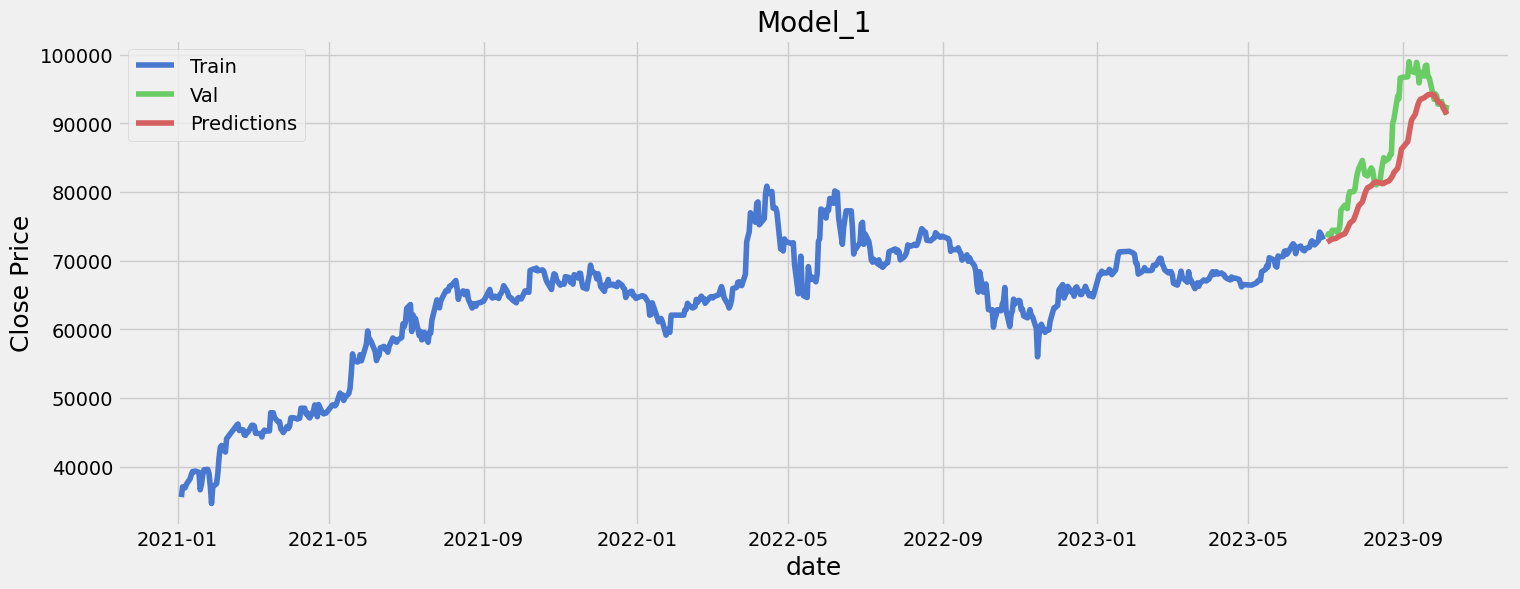

In [64]:
plt.style.use("seaborn-v0_8-muted")
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions1'] = predictions1

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_1')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions1']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


GRU Model

In [65]:
# Creat RNN
RNN2 = tf.keras.models.Sequential()
# The First GRU Layer
RNN2.add(tf.keras.layers.GRU(units=130, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
# The Second GRU Layer
RNN2.add(tf.keras.layers.GRU(units=65, return_sequences=False, activation='tanh'))
# The Connection
RNN2.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN2.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN2.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_2 = RNN2.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
19/19 [==============================] - 6s 87ms/step - loss: 0.0323 - accuracy: 0.0000e+00 - val_loss: 7611264000.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 1s 38ms/step - loss: 0.0026 - accuracy: 0.0000e+00 - val_loss: 7611254272.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 1s 35ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 7611246080.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 1s 36ms/step - loss: 8.3044e-04 - accuracy: 0.0000e+00 - val_loss: 7611240960.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 1s 36ms/step - loss: 6.2017e-04 - accuracy: 0.0000e+00 - val_loss: 7611237888.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
19/19 [==============================] - 1s 36ms/step - loss: 5.5919e-04 - accuracy: 0.0000e+00 - val_loss: 7611238400.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
19/19 [======================

In [66]:
# Geting The Model Predicted Price Values
predictions2 = RNN2.predict(X_test)
# Converting scaled number to actual number
predictions2 = scaler.inverse_transform(predictions2)


3/3 [==============================] - 1s 7ms/step


In [67]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions2)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions2)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions2))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions2)}')


Mean Absolute Error: 1747.9725413602941
Mean Squared Error: 5111310.285824944
Root Mean Squared Error: 2260.820710676754
R2_Score: 0.9247687887929679


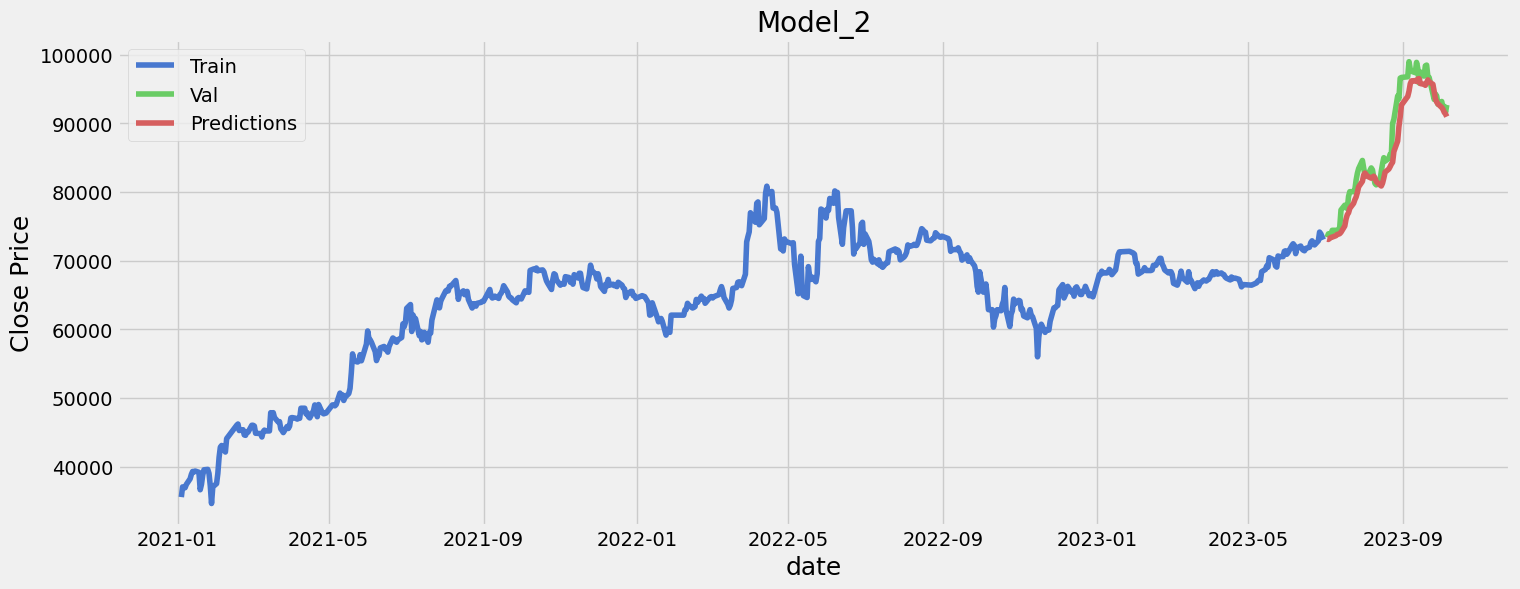

In [68]:
plt.style.use("seaborn-v0_8-muted")
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions2'] = predictions2

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_2')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions2']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


LSTM & Bidirectional

In [69]:
RNN3 = tf.keras.models.Sequential()
# The First Bidirectional & LSTM  Layer
RNN3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=130, return_sequences=True, input_shape=(X_train.shape[1],1))))
# The Second Bidirectional & LSTM Layer
RNN3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=65, return_sequences=False)))
# The Connection
RNN3.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN3.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN3.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_3 = RNN2.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
19/19 [==============================] - 1s 38ms/step - loss: 4.9909e-04 - accuracy: 0.0000e+00 - val_loss: 7611234816.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 1s 34ms/step - loss: 4.9442e-04 - accuracy: 0.0000e+00 - val_loss: 7611235328.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 1s 36ms/step - loss: 4.6917e-04 - accuracy: 0.0000e+00 - val_loss: 7611235328.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 1s 35ms/step - loss: 4.5170e-04 - accuracy: 0.0000e+00 - val_loss: 7611233280.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 1s 36ms/step - loss: 4.8915e-04 - accuracy: 0.0000e+00 - val_loss: 7611235328.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
19/19 [==============================] - 1s 35ms/step - loss: 4.5740e-04 - accuracy: 0.0000e+00 - val_loss: 7611235328.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
19/19 [==========

In [70]:
# Geting The Models Predicted Price Values
predictions3 = RNN3.predict(X_test)
# Converting scaled number to actual number
predictions3 = scaler.inverse_transform(predictions3)


3/3 [==============================] - 4s 12ms/step


In [71]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions3)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions3)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions3))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions3)}')


Mean Absolute Error: 58579.48316865809
Mean Squared Error: 3513332378.269158
Root Mean Squared Error: 59273.36989128556
R2_Score: -50.71125120755857


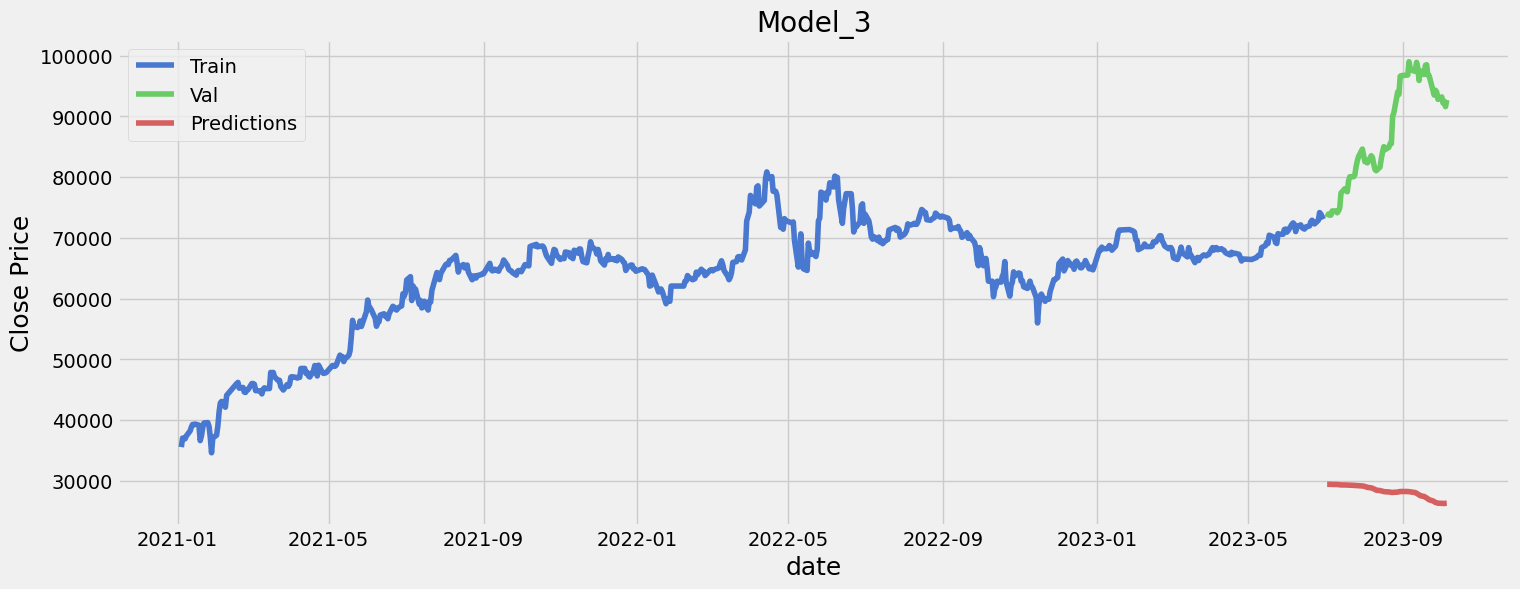

In [72]:
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions3'] = predictions3

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_3')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions3']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


LSTM & GRU

In [73]:
# Creat RNN
RNN4 = tf.keras.models.Sequential()
# The First Layer of LSTM
RNN4.add(tf.keras.layers.LSTM(units=130, return_sequences=True, input_shape=(X_train.shape[1],1)))
# The Second Layer of GRU
RNN4.add(tf.keras.layers.GRU(units=65, return_sequences=False, activation='tanh'))
# The Connection
RNN4.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN4.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN4.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_4 = RNN4.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
19/19 [==============================] - 8s 130ms/step - loss: 0.0435 - accuracy: 0.0000e+00 - val_loss: 7611268096.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 1s 65ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 7611260416.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 1s 58ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 7611253248.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 1s 63ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 7611247104.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 1s 58ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 7611239936.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
19/19 [==============================] - 1s 55ms/step - loss: 9.0134e-04 - accuracy: 0.0000e+00 - val_loss: 7611239936.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
19/19 [=============================

In [74]:
# Geting The Models Predicted Price Values
predictions4 = RNN4.predict(X_test)
# Converting scaled number to actual number
predictions4 = scaler.inverse_transform(predictions4)


3/3 [==============================] - 1s 22ms/step


In [75]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions4)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions4)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions4))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions4)}')


Mean Absolute Error: 2202.5094209558824
Mean Squared Error: 8796571.762664795
Root Mean Squared Error: 2965.90150926574
R2_Score: 0.8705269860039337


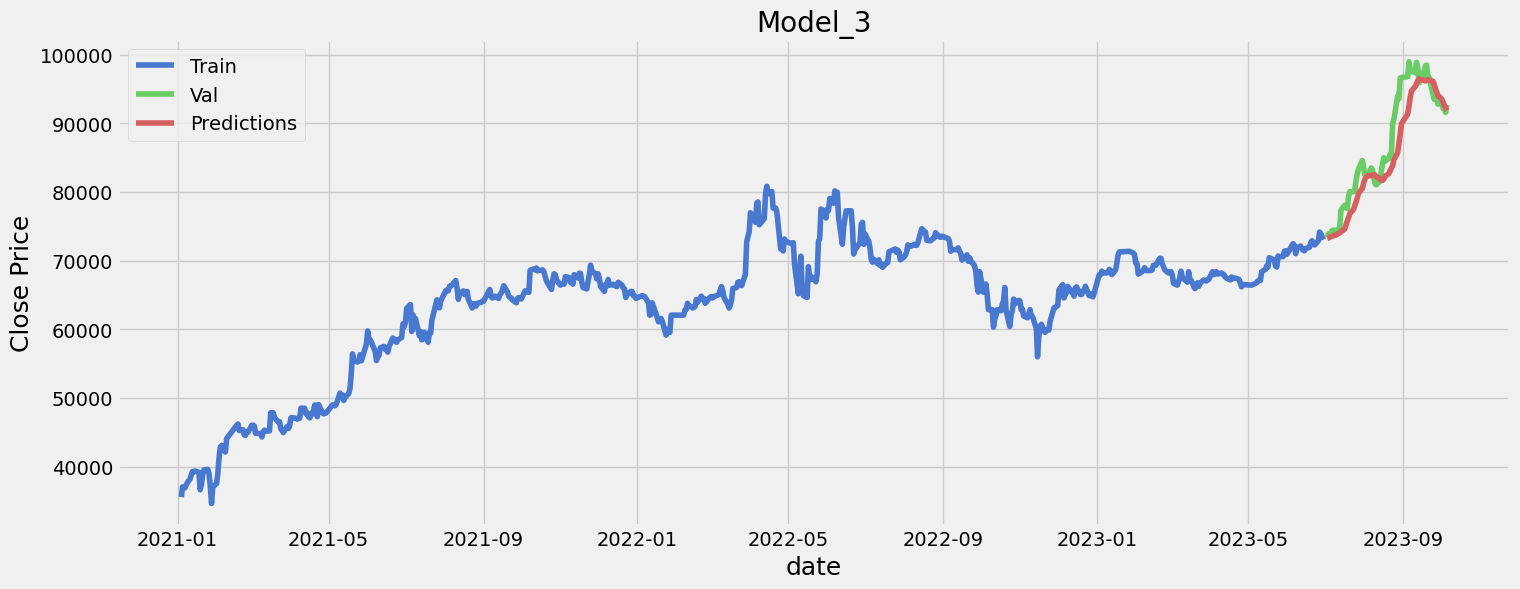

In [76]:
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions4'] = predictions4

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_3')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions4']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


# Trading Agent

Turtle trading strategy

In [77]:
count = int(np.ceil(len(df2) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals.head()


,signal,trend,RollingMax,RollingMin
0,0.0,35560,NaN,NaN
1,0.0,37050,NaN,NaN
2,0.0,36880,NaN,NaN
3,0.0,36930,NaN,NaN
4,0.0,37410,NaN,NaN


In [78]:
def buy_stock(
    real_movement,              # Giá thực tế
    signal,                     # Tín hiệu mua bán
    initial_money = 100000,     # Số tiền ban đầu
    max_buy = 1,                # Lượng mua tối đa
    max_sell = 1,               # Lượng bán tối đa
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money  # Số tiền ban đầu
    states_sell = []                # Danh sách các ngày bán
    states_buy = []                 # Danh sách các ngày mua
    current_inventory = 0           # Lượng tài sản hiện tại

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest


In [79]:
states_buy, states_sell, total_gains, invest = buy_stock(df2['close'], signals['signal'])


day 71: cannot sell anything, inventory 0
day 73: cannot sell anything, inventory 0
day 82: cannot sell anything, inventory 0
day 88: cannot sell anything, inventory 0
day 89: cannot sell anything, inventory 0
day 90: cannot sell anything, inventory 0
day 97: cannot sell anything, inventory 0
day 98: cannot sell anything, inventory 0
day 118: cannot sell anything, inventory 0
day 120: cannot sell anything, inventory 0
day 121: cannot sell anything, inventory 0
day 122: cannot sell anything, inventory 0
day 137: cannot sell anything, inventory 0
day 141: cannot sell anything, inventory 0
day 142: cannot sell anything, inventory 0
day 143: cannot sell anything, inventory 0
day 145: cannot sell anything, inventory 0
day 147: cannot sell anything, inventory 0
day 148: cannot sell anything, inventory 0
day 189: cannot sell anything, inventory 0
day 190: cannot sell anything, inventory 0
day 192: cannot sell anything, inventory 0
day 223: cannot sell anything, inventory 0
day 254: buy 1 unit

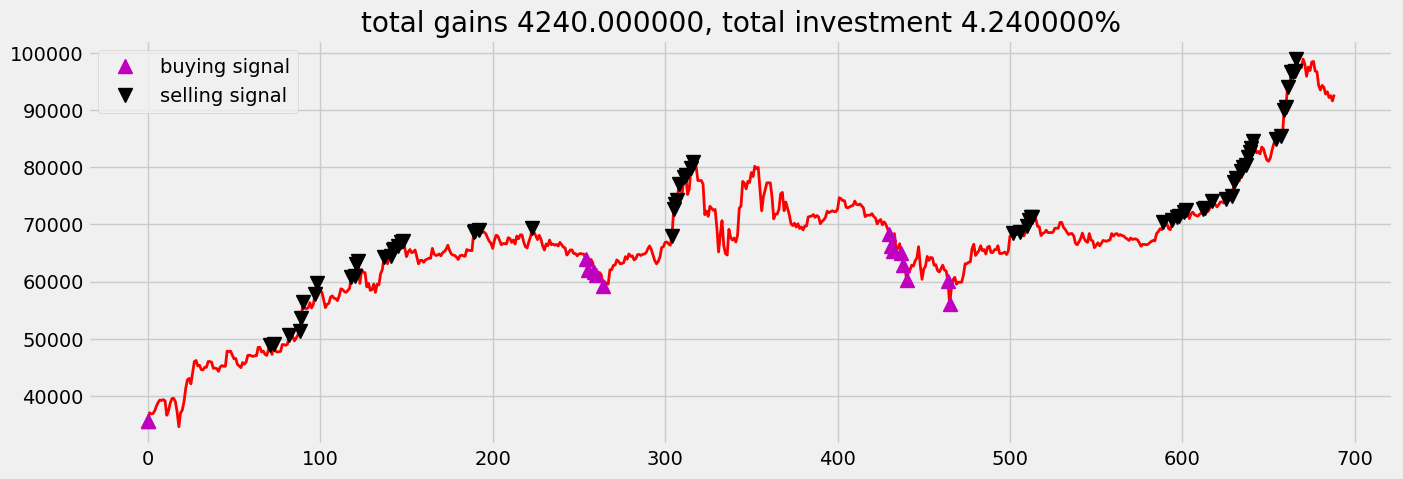

In [80]:
close = df2['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()


Deep Evolution Strategy

In [81]:
class DeepEvolutionStrategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def getWeights(self):
        return self.weights

    def train(self, epoch=100, print_every=1):
            lasttime = time.time()
            for i in range(epoch):
                population = []
                rewards = np.zeros(self.population_size)
                for k in range(self.population_size):
                    x = []
                    for w in self.weights:
                        x.append(np.random.randn(*w.shape))
                    population.append(x)
                for k in range(self.population_size):
                    weights_population = self._get_weight_from_population(
                        self.weights, population[k]
                    )
                    rewards[k] = self.reward_function(weights_population)
                rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
                for index, w in enumerate(self.weights):
                    A = np.array([p[index] for p in population])
                    self.weights[index] = (
                        w
                        + self.learning_rate
                        / (self.population_size * self.sigma)
                        * np.dot(A.T, rewards).T
                    )
                if (i + 1) % print_every == 0:
                    print(
                        f'Training Epoch {i + 1}. Final Reward: {self.reward_function(self.weights)}'
                    )
            print('=====================================')
            print(f'Training Time: {time.time() - lasttime} seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def getWeights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.weights, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            self.weights = pickle.load(file)


In [82]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = DeepEvolutionStrategy(
            self.model.getWeights(),
            self.getReward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def getState(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def getReward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.getState(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every=checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.getState(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('Day %s > Buy 1 share at price %s, Total Asset %s' % (
                    str(t).rjust(3),
                    str("%.5f" % self.trend[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10)
                ))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('Day %s > Sell 1 share at price %s, Total Asset %s > Profit %s %%' % (
                    str(t).rjust(3),
                    str("%.5f" % close[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10),
                    str("%.2f" % invest).rjust(5)
                ))
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


In [83]:
close = df2["close"].tolist()
window_size = 30
skip = 1
initial_money = 100000


In [84]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model,
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 100)

model.save_model('D:\Time-series-forecasting\model\deepES_model_FPT.hdf5')


Training Epoch 100. Final Reward: 275.163
Training Epoch 200. Final Reward: 298.873
Training Epoch 300. Final Reward: 322.291
Training Epoch 400. Final Reward: 323.562
Training Epoch 500. Final Reward: 387.185
Training Time: 1260.9184279441833 seconds


In [85]:
states_buy, states_sell, total_gains, invest = agent.buy()


Day   3 > Buy 1 share at price 36930.00000, Total Asset  63070.000
Day   4 > Buy 1 share at price 37410.00000, Total Asset  25660.000
Day  14 > Sell 1 share at price 39540.00000, Total Asset  65200.000 > Profit  7.07 %
Day  15 > Sell 1 share at price 39600.00000, Total Asset 104800.000 > Profit  5.85 %
Day  19 > Buy 1 share at price 37050.00000, Total Asset  67750.000
Day  20 > Buy 1 share at price 37530.00000, Total Asset  30220.000
Day  23 > Sell 1 share at price 42840.00000, Total Asset  73060.000 > Profit 15.63 %
Day  26 > Buy 1 share at price 44080.00000, Total Asset  28980.000
Day  35 > Sell 1 share at price 46030.00000, Total Asset  75010.000 > Profit 22.65 %
Day  36 > Sell 1 share at price 46030.00000, Total Asset 121040.000 > Profit  4.42 %
Day  40 > Buy 1 share at price 44800.00000, Total Asset  76240.000
Day  41 > Buy 1 share at price 44320.00000, Total Asset  31920.000
Day  46 > Sell 1 share at price 47860.00000, Total Asset  79780.000 > Profit  6.83 %
Day  47 > Sell 1 shar

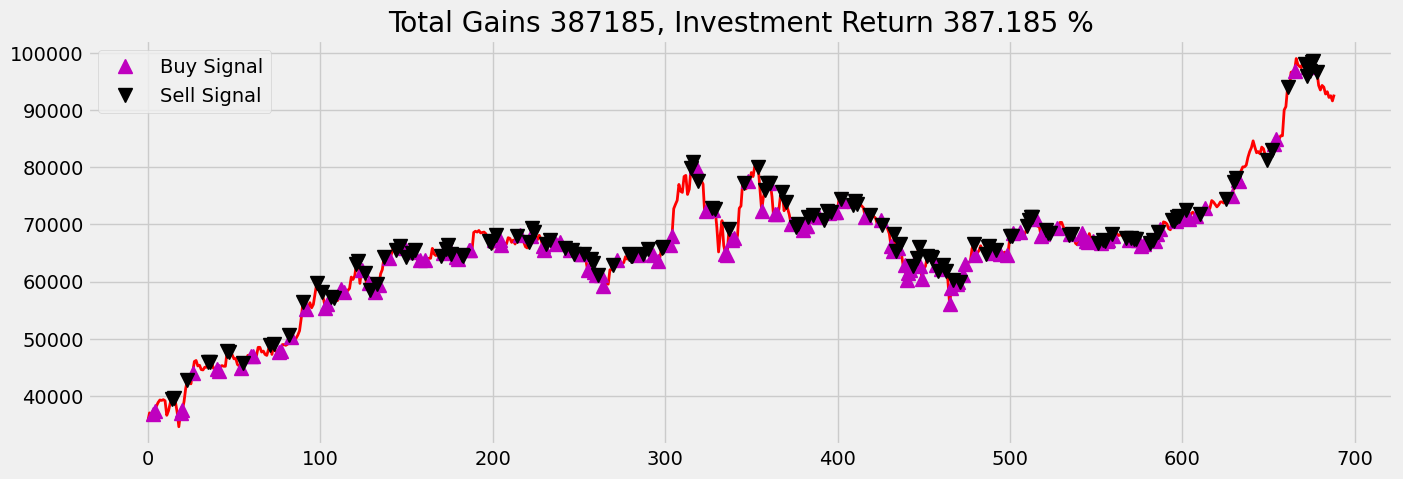

In [86]:
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label='Buy Signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='Sell Signal', markevery=states_sell)
plt.title(f'Total Gains {total_gains}, Investment Return {invest} %')
plt.legend()
plt.show()
